<a href="https://colab.research.google.com/github/yestrella14/DS-Unit-2-Linear-Models/blob/master/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

Yeraldina

In [3]:
df =df.reset_index()
df = df.drop('index', axis=1)

In [4]:
#Import the plotting libraries
import plotly.express as px
import matplotlib.pyplot as plt


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48817 entries, 0 to 48816
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   created               48817 non-null  object 
 3   description           47392 non-null  object 
 4   display_address       48684 non-null  object 
 5   latitude              48817 non-null  float64
 6   longitude             48817 non-null  float64
 7   price                 48817 non-null  int64  
 8   street_address        48807 non-null  object 
 9   interest_level        48817 non-null  object 
 10  elevator              48817 non-null  int64  
 11  cats_allowed          48817 non-null  int64  
 12  hardwood_floors       48817 non-null  int64  
 13  dogs_allowed          48817 non-null  int64  
 14  doorman               48817 non-null  int64  
 15  dishwasher         

**Engineer at least two new features**

In [6]:
#New feature cats and dogs alowed
df['pets_allowed'] = (df['cats_allowed']==1) &(df['dogs_allowed']==1)
df['pets_allowed'] = df['pets_allowed'].replace({False:0, True:1})

In [47]:
#Entertaiment perks
df['entertaiment'] = df['fitness_center']+df['roof_deck']+df['swimming_pool']+df['outdoor_space']+df['terrace']+df['common_outdoor_space']
df.sample()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,pets_allowed,month_year,contains_description,entertaiment
28548,1.0,2,2016-05-15 02:27:11,THIS IS A MUST SEE AND WONT LAST!PRIME LOCATIO...,East 35th Street,40.7466,-73.9779,3450,165 East 35th Street,low,1,0,1,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,2016-05,THIS IS A MUST SEE AND WONT LAST!PRIME LOCATIO...,2


In [24]:
df['description'][1]

'        '

In [23]:
len(df['description'][1])

8

In [42]:
df['contains_description'] = df['description'].replace({len(df['description']==8): '0'})
df[['description', 'contains_description']].head()

,description,contains_description
0,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...
1,,
2,"Top Top West Village location, beautiful Pre-w...","Top Top West Village location, beautiful Pre-w..."
3,Building Amenities - Garage - Garden - fitness...,Building Amenities - Garage - Garden - fitness...
4,Beautifully renovated 3 bedroom flex 4 bedroom...,Beautifully renovated 3 bedroom flex 4 bedroom...


**Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test**

In [48]:
#Change the create column to datetime type
df['created']= pd.to_datetime(df['created'])
df['created'].dtypes

dtype('<M8[ns]')

In [49]:
df['created']

0       2016-06-24 07:54:24
1       2016-06-12 12:19:27
2       2016-04-17 03:26:41
3       2016-04-18 02:22:02
4       2016-04-28 01:32:41
                ...        
48812   2016-06-02 05:41:05
48813   2016-04-04 18:22:34
48814   2016-04-16 02:13:40
48815   2016-04-08 02:13:33
48816   2016-04-12 02:48:07
Name: created, Length: 48817, dtype: datetime64[ns]

In [50]:
df['month_year'] = pd.to_datetime(df['created']).dt.to_period('M')
df[['created', 'month_year']].head(2)

,created,month_year
0,2016-06-24 07:54:24,2016-06
1,2016-06-12 12:19:27,2016-06


In [51]:
df_train = df[(df['month_year']>='2016-04')& (df['month_year']<='2016-05')]
print(df_train.shape)
print(df.shape)
df_train.head(2)


(31844, 38)
(48817, 38)


,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,pets_allowed,month_year,contains_description,entertaiment
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04,"Top Top West Village location, beautiful Pre-w...",0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04,Building Amenities - Garage - Garden - fitness...,0


In [52]:
df_test= df[df['month_year']=='2016-06']
print(df_test.shape)
print(df.shape)
df_test.head(2)

(16973, 38)
(48817, 38)


,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,pets_allowed,month_year,contains_description,entertaiment
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-06,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-06,,1


In [53]:
from sklearn.linear_model import LinearRegression
#Class initiation
model = LinearRegression()

In [54]:
#Target variable declaration
target= ['price']
#Feature variable declaration
features = ['bathrooms','bedrooms', 'pets_allowed', 'entertaiment','no_fee', 'elevator', 'dishwasher', 'balcony']

In [55]:
#Train Features and target
#Train feature matrix 
X_train=df_train[features]
#Train target vector
y_train=df_train[target]

#Test Featiures and target
#Test feature matrix
X_test=df_test[features]
#Test target vector
y_test=df_test[target]


In [65]:
#Model fit
model.fit(X_train, y_train)
#Prediction of y_value on the training data
y_predictTrain=model.predict(X_train)

#Prediction of y_value on the testing data
y_predictTest=model.predict(X_test)


Get the model's coefficients and intercept.

 Get regression metrics RMSE, MAE, and  R2 , for both the train and test data.

 What's the best test MAE you can get? Share your score and features used with your cohort on Slack!


In [73]:
# Train Error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



**Get regression metrics RMSE, MAE, and R2 , for both the train and test data.**

In [71]:
#RMSE


#MAE
mae_train=mean_absolute_error(y_train, y_predictTrain)
print('The Mean Absolute error for the train Data is:',mae_train)


mae_test=mean_absolute_error(y_test, y_predictTest)
print('The Mean Absolute error for the test data is:',mae_test)
#R2

r2=metrics.r2_score(y_test, y_predictTest)
print('The R2 value is:', r2)

The Mean Absolute error for the train Data is: 784.5551209310296
The Mean Absolute error for the test data is: 790.4660415357049
The R2 value is: 0.5485480161625447


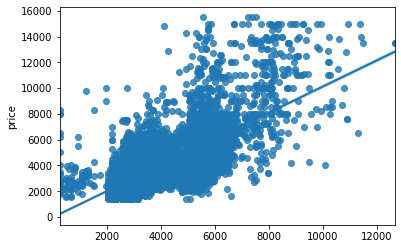

In [75]:
sns.regplot(x=y_predict, y=y_test)